<font size="4"> <b>Colorful Image Colorizations - Demo Code</b><br></font>
Richard Zhang, Phillip Isola, Alyosha Efros</br>

In [1]:
!apt install caffe-cuda
!git clone -l -s https://github.com/ritusingla/colorization/ colorization
%cd colorization


Reading package lists... Done
Building dependency tree       
Reading state information... Done
caffe-cuda is already the newest version (1.0.0-6build1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
fatal: destination path 'colorization' already exists and is not an empty directory.
/content/colorization


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import caffe
import os
import skimage.color as color
import scipy.ndimage.interpolation as sni

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

(0) <b> Get the model </b> Download the colorization model

In [3]:
!wget -O models/colorization_release_v1.caffemodel http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel

--2020-05-25 14:24:16--  http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel [following]
--2020-05-25 14:24:16--  https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128948189 (123M)
Saving to: ‘models/colorization_release_v1.caffemodel’

models/colorization 100%[===================

(1) <b> Opening the model </b> First, we need to open the caffemodel. The model input blob is <i>data_l</i>, and has shape 1x1x224x224 by default. The model output is <i>class8_ab</i>, and has shape 1x2x56x56. We also need to set the temperature T for the annealed mean operation. Blob <i>Trecip</i> is the <i> reciprocal </i> of the temperature.

In [0]:
gpu_id = 0
caffe.set_mode_gpu()
caffe.set_device(gpu_id)
net = caffe.Net('models/colorization_deploy_v1.prototxt', 'models/colorization_release_v1.caffemodel', caffe.TEST)

(H_in,W_in) = net.blobs['data_l'].data.shape[2:] # get input shape
(H_out,W_out) = net.blobs['class8_ab'].data.shape[2:] # get output shape
net.blobs['Trecip'].data[...] = 6/np.log(10) # 1/T, set annealing temperature
    # (We found that we had introduced a factor of log(10). We will update the arXiv shortly.)

<b> (2) Loading the image </b> Next, we need to load our image of choice. We will convert the image at its full resolution to <i>Lab</i> and keep it's <i>L</i> value; we will concatenate the network's color to it! We then resize the image to the network input size, convert to <i>Lab</i>, and only keep the resized <i>L</i>, since network of course does not get any color inputs!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


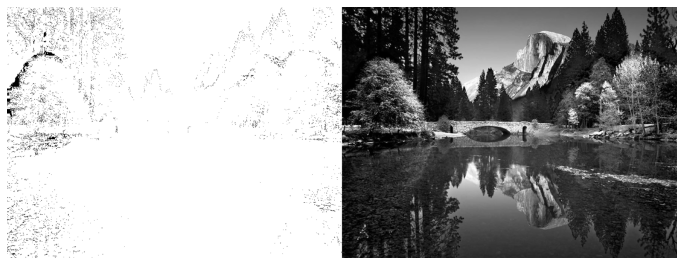

In [5]:
# load the original image
import cv2
img_rgb = cv2.imread('demo/imgs/ansel_adams3.jpg')
img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.shape[:2] # original image size

# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)

# resize image to network input size
img_rs = caffe.io.resize_image(img_rgb,(H_in,W_in)) # resize image to network input size
img_lab_rs = color.rgb2lab(img_rs)
img_l_rs = img_lab_rs[:,:,0]

# show original image, along with grayscale input
# img_pad = np.ones((H_orig,W_orig/10,3))
plt.imshow(np.hstack((img_rgb,  img_rgb_bw)))
plt.axis('off');

<b> (3) Colorization time!</b> Now it is time to run the network. We subtract 50 from the <i>L</i> channel (for mean centering), push it into the network, and run a forward pass. Then, we take the output from <i>class8_ab</i>, resize it to the full resolution, concatenate with the <i>L</i> channel, convert to rgb, and display the result.

In [0]:
net.blobs['data_l'].data[0,0,:,:] = img_l_rs-50 # subtract 50 for mean-centering
net.forward() # run network

ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = np.clip(color.lab2rgb(img_lab_out),0,1) # convert back to rgb

plt.imshow(img_rgb_out);
plt.axis('off');

<b> (4) Share your results with us</b> Should you wish to share your colorizations with us, please email Richard Zhang with subject <i><b>MyColorization</b></i> at [rich.zhang@eecs.berkeley.edu](rich.zhang@eecs.berkeley.edu).